# Module 2: Introduction to Analyzing Spectra

This module will showcase some of the techniques that we use to analyze spectra. Things that we will go over in this notebook are:

1. How to compute the redshift of a source
2. How to fit a continuum to the spectrum
3. How to measure Emission Lines
4. How to fit multi-component models



In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

plt.style.use('ggplot')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 15

# Introduction to Spectral Analysis

As astronomers our main bread and better comes when we are able to study light from an object. This light gives us invaluable information about the chemical composition, the strength of the ionization field that leads to emission lines, as well as information about the dust properties within a galaxy and so much more. When we are studying galaxies in escense what we are studying is the summation of all the stars that make up the galaxy as well as all the post processing of that light through dust and gas. 

## How do we take a Spectrum

Typically when we take a spectra, we apply what is called a mask. You can think of this mask as being a small little rectangular box that.The image below shows an example of this using the NIRSpec instrument on JWST. With the rectangle shown where the spectrograph is getting the light from the galaxy.



The light from the galaxy enters the box or $\textbf{slit}$ and then it encounters a disperser that spreads out the light at different wavelength. At each wavelength we measure the amount of photons that hot the detector and there are certain wavelength that have more strength than the surrounding area and these areas of a boost in strength are typically called $\textbf{Emission Line}$. Which come from the recombination of atoms in the galaxy providing a boost in signal at specific wavelengths. You can also see a reduction in flux from the surrounding areas and this is what is called $\textbf{Absorption Lines}$. The Absorption Lines typically come about when light from stars encounters relatively cool gas, that gas then absorbs the light and moves the atom to an excited state, and when it decays back to the ground state the light is emitted in a random direction which, most of the time, removes the light from our line of sight. 

When the light encounters our detector this is done on a 2D Charge-Coupled Device or CCD, so when we get the spectra it is not a 1D spectra that we are all familiar with but a 2D spectra as seen below:


The top panel of this plot is that 2D spectra that is encoded into the CCD and then we go in and apply some code to extract the 1D-spectra that we see below. This is due to summing up the flux along the columns and collapsing this 2D-array into a 1D-Array.

## Spectral Resolution

One of the most important aspect of a spectroscopic instrument is the resolution. You can think of the resolution of an instrument as how finely separated are two neighboring wavelengths. The higher the resolution the smaller the spacing between neighboring wavelengths. This is super important if you need to be able to resolve doublets, which are two emission lines in very close proximity. If the resolution is really low you can imaging that doublets would actually look like one line instead of two. There are ways to fit emission lines with multi-Gaussian when the resolution is low and back out information, with some assumption, which we will cover in the end of the notebook.
You can see an example of the difference that resolution makes in the following image where with a higher resolution spectra you can really make out the individual emission features where if you have a lower resolution spectra the lines can blur together and gaining information from that spectra is more difficult, but not impossible.

# What does the Spectra Tell Us?

1. Redshift

Spectra tell us so much information. For one, we can use the spectra to find the redshift of the source. Do you see those vertical dashed lines in the 1D-spectra above? Those lines occur at a fixed wavelength and we can measure how far off those emission lines are from where they are from the rest frame and we can use the equation below to get the redshift. 

$z = \lambda_{obs}/\lambda_{rest} - 1$

2. Galaxy Properties

The strength of those emission lines can give us insight into the internal galaxy properties. By measuring the flux of lines across the spectra and by using certain equations we can get relevant galaxy properties like; metallicity, ionization parameter, dust content, Star Formation Rate, and more. The way that we measure the flux of an emission line is by fitting the line to a Gaussian Model as emission lines are really well modeled by a Gaussian. The integral of this Gaussian will tell you the integrated flux of this line. Depending on this line you can measure properties from this single line or you would need to measure other lines and pair this line with that to get galaxy properties. We cover in this notebook how to fit a line to a Gaussian Model and in part 2, how we can use a Bayesian model for the fitting. 

# A Note on Units

When dealing with spectra they will most likely come in two flux units $F_{\nu}$ or $F_{\lambda}$. The units for each of these differ slightly where in $F_{\nu}$ the base cgs unit is $erg/s/cm^2/Hz$, other units are scaled versions of this base unit such as a Jansky (Jy for short) which is 1 $\times$ $10^{-23}$ $erg/s/cm^2/Hz$. The typical order of magnitude for these sources is of order $10^{-30}$ - $10^{-26}$ for $erg/s/cm^2/Hz$. 

In $F_{\lambda}$, the base cgs unit is $erg/s/cm^2/\AA$. The typical order of magnitude of fluxes for spectra in these units is of order $10^{-21}$ - $10^{-16}$ in $erg/s/cm^2/\AA$. 

## Converting Between the Two

One of the things we will be working on in this notebook and whenever you are dealing with spectra is measuring the flux of a source for that we need the units to be in units of $erg/s/cm^2$. This means that if you are measuring fluxes, you will need to be careful about the units of the spectrum you are fitting. If you have a spectrum that is in $F_{\nu}$ and you need to get to $F_{\lambda}$ the way to do that is to apply the following equation:

   $ F_{\lambda} = \frac{c}{\lambda^2} F_{\nu}$

   Where $F_{\nu}$ is in $erg/s/cm^2/\AA$, c is the speed of light in Angstroms/second, and $\lambda$ is in Angstroms. 

To go the other way from $F_{\lambda}$ to $F_{\nu}$ we do the following equation:


   $ F_{\nu} = \frac{\lambda^2}{c} F_{\lambda}$

Where $F_{\lambda}$ is in units of $erg/s/cm^2/\AA$, c is the speed of light in Angstroms/second. If your spectrum does not have wavelengths but frequency you can always use the relation of the speed of light $c = \lambda \nu$ to change one of the variables to the other.

In [91]:
def convert_Flambda_to_Fnu(wavelength, flambda):
    
    '''
    Function to convert flux density from flambda to fnu.

    Inputs:

    wavelength: float, wavelength in Angstroms
    flambda: float, flux density in erg/s/cm^2/Angstrom

    Returns:

    fnu: float, flux density in erg/s/cm^2/Hz

    '''

    #speed of light in m/s
    c_m_s = 3e8

    #speed of light in Angstrom/s
    c_AA_s = c_m_s * 1e10

    #getting Fnu from Flambda
    fnu = flambda * ((wavelength**2)/c_AA_s)

    return fnu


def convert_Fnu_to_Flambda(wavelength, fnu):
    
    '''
    Function to convert flux density from flambda to fnu.

    Inputs:

    wavelength: float, wavelength in Angstroms
    fnu: float, flux density in erg/s/cm^2/HZ

    Returns:

    fnu: float, flux density in erg/s/cm^2/Angstrom

    '''

    #speed of light in m/s
    c_m_s = 3e8

    #speed of light in Angstrom/s
    c_AA_s = c_m_s * 1e10

    #getting Fnu from Flambda
    flambda = fnu * (c_AA_s / (wavelength**2))

    return flambda

# Spectral Analysis in Python

In [92]:
#reading in the data for one of the spectra
table = Table.read('spectra_data3.fits')

In [93]:
print(table)

    flux    loglam     ivar     and_mask ...   wdisp       sky      model   
----------- ------ ------------ -------- ... ---------- --------- ----------
 0.13598591  3.553  0.118256964        0 ...  1.7429501 3.4696877 0.45155445
  1.6061269 3.5531          0.0        0 ...  1.7432734 3.6680524 0.41732463
  3.0766983 3.5532   0.11378371        0 ...  1.7436013  3.758805  0.3794025
 -1.1138248 3.5533   0.12132751        0 ...    1.74393  3.843181  0.3431368
  1.4159236 3.5534    0.1273667        0 ...  1.7442518  3.882553 0.31622276
  3.0341332 3.5535   0.12627988        0 ...  1.7445669 3.9144127  0.2996966
 -2.2946932 3.5536   0.14033173        0 ...  1.7448941 3.8829503 0.29394022
 -2.0978203 3.5537   0.14548878        0 ...  1.7452136 3.7444098 0.31752843
 -3.5846295 3.5538   0.14958404        0 ...  1.7455292 3.6192603 0.36722457
-0.23778848 3.5539   0.14847949        0 ...   1.745843 3.4895587  0.4153492
        ...    ...          ...      ... ...        ...       ...        ...

In [94]:
#We want just the flux and wavelength so we will use columns "flux" and "loglam" = log10(lambda)
wavelength = 10**table['loglam'] #to get rid of the log we raise it to the 10th power
flux = table['flux']

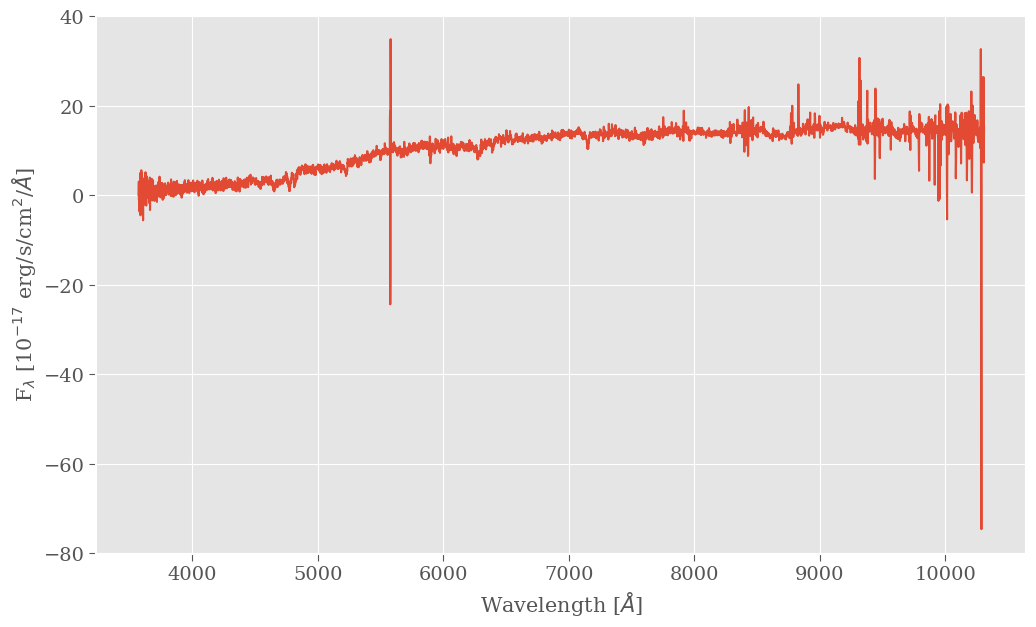

In [95]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux)
plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.tick_params(labelsize = 14, length = 5)
plt.show()

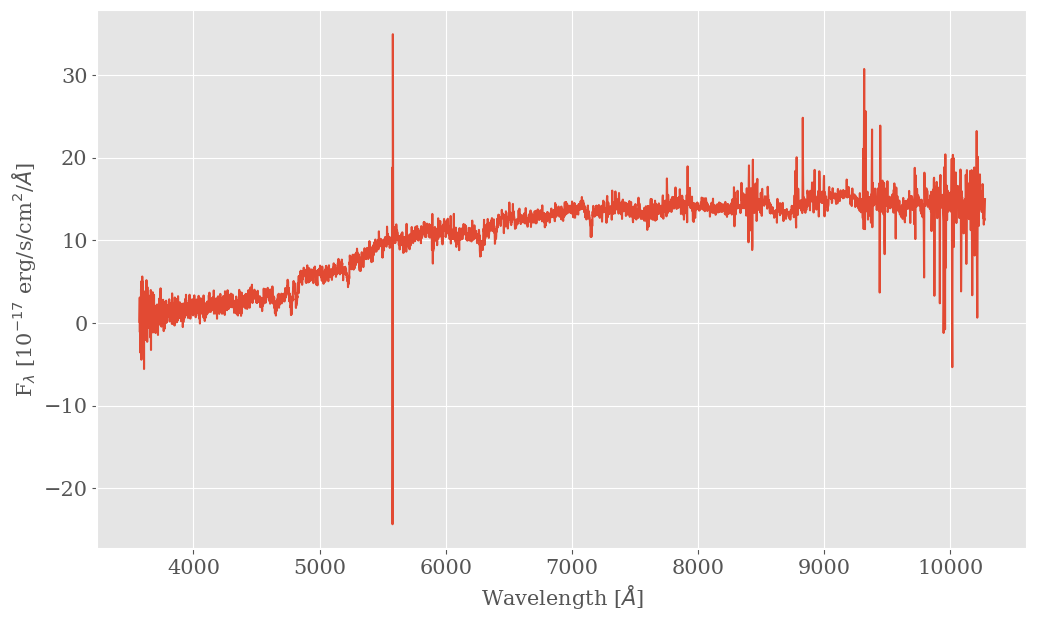

In [96]:
#remove the rightmost noisy feature
clip = 15

wavelength, flux = wavelength[:-clip], flux[:-clip]

plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux)
plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.show()


# Step 1: Find Redshift

The way we find out the redshift of the galaxy is by matching known emission or absorption features in the spectrum and seeing how far they have been shifted out of their expected rest-frame position. 

In this spectrum it is very noisy and so using emission features could work but it is not a typical star forming galaxy instead we will use absorption features to help us out here. Close to the 5000 Angstrom mark there is a typical feature found in cool stars called the H and K lines. We will use those lines to fit the redshift.

In [97]:
line_names = ['H', 'K']
line_wavelengths = np.array([3968, 3934]) #rest frame wavelengths for H and K lines

In [98]:
#input your guess for a redshift here (Hint: redshift is between 0 - 1)
z = 

#line that redshifts the lines
redshifted_lines = (1+z) * line_wavelengths

#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, medfilt(flux, 5))

#plotting vertical lines for the spectra
plt.axvline(redshifted_lines[0], color = 'black')
plt.annotate(line_names[0], (redshifted_lines[0]+50, 20))
plt.axvline(redshifted_lines[1], color = 'black')
plt.annotate(line_names[1], (redshifted_lines[1]-200, 20))

plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.show()

SyntaxError: invalid syntax (164757085.py, line 2)

# 2. Fitting/Removing the Continuum

The continuum holds the shape of the underlying stellar population of a galaxy but it does mess up our ability to measure the flux of a line properly so what we need to do is to somehow fit the broad shape of the continuum so that we can perform accurate line fitting. One technique is applying a broad window filter that will smooth out all the local bumps and wiggles to get the shape of the continuum. You will need to mess around with the optimal window as a window that is too small will reproduce emission and absorption features and we do not want that or a window that is too large will overly smooth so some trial and error is needed to get it just right. Also If you see prominant emission lines in your spectra it would be wise to mask them out (remove them) from the spectra when doing this continuum fitting. This spectra does not have any large emission features so we will just use the broad window filter

In [ ]:
from scipy.signal import medfilt
from scipy.signal import savgol_filter

In [ ]:
#We need to specify window length try it out and see which window length works best 
#Note: Window length must be odd, and in this case will be quite big
window = 101
continuum_medfilt = medfilt(np.array(flux).astype(float), kernel_size =int(window))
continuum_savgol = savgol_filter(np.array(flux).astype(float), window_length = int(window), polyorder = 3)

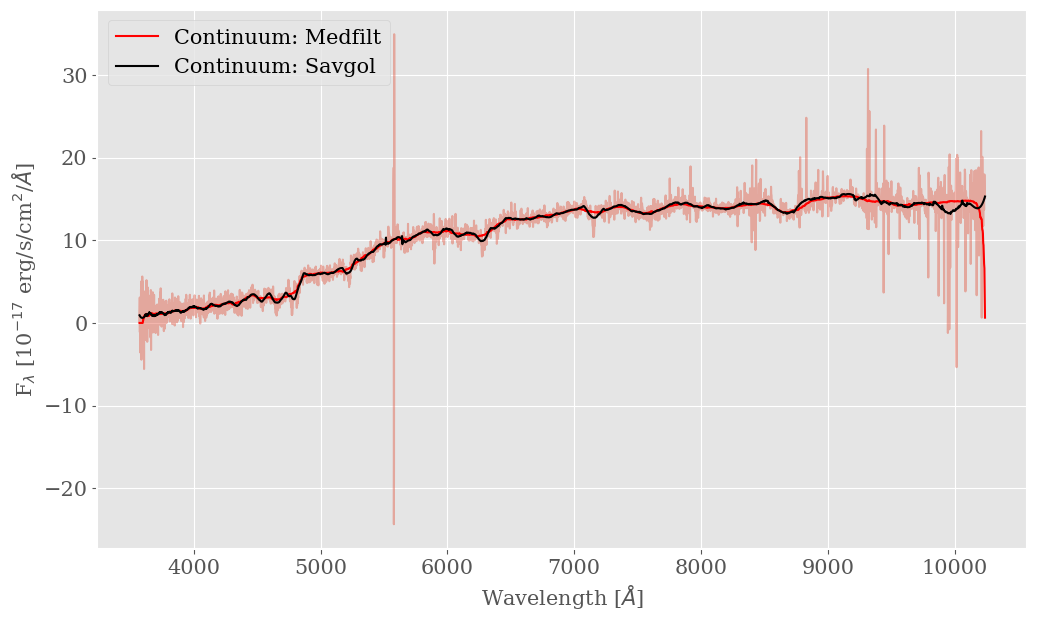

In [ ]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux, alpha = 0.4)

l1, = plt.plot(wavelength, continuum_medfilt, color = 'red')
l2, = plt.plot(wavelength, continuum_savgol, color = 'black')



plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)

plt.legend(handles = [l1, l2], 
           labels = ['Continuum: Medfilt', 
                     'Continuum: Savgol'], 
          fontsize = 15)

plt.show()

In [ ]:
#normalizing the spectrum
#This sets the spectra to be around a value of 1
norm_spec_medfilt = flux/continuum_medfilt
norm_spec_savgol = flux/continuum_savgol

/var/folders/t2/6968g8md2c9g1mm1h0p9nxl588s4s1/T/ipykernel_29995/2881425453.py:3: RuntimeWarning: divide by zero encountered in divide
  norm_spec_medfilt = flux/continuum_medfilt


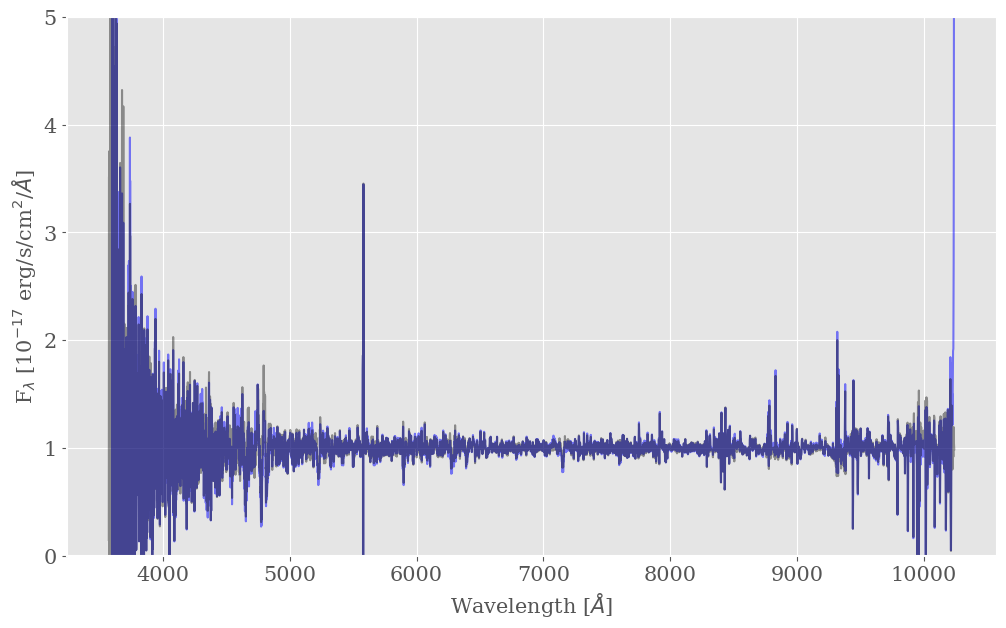

In [ ]:
#plotting Spectrum
plt.figure(figsize = (12, 7))

plt.plot(wavelength, norm_spec_medfilt, color = 'blue', alpha = 0.5)
plt.plot(wavelength, norm_spec_savgol, color = 'black', alpha = 0.4)

plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.ylim(0, 5)
plt.show()

# Another Example

Let us try using our spectral analysis techniques on another galaxy. This time on a CEERS NIRSpec spectra.

In [ ]:
#reading in the file
nirspec_2552 = Table.read('spectra_data1.fits')

In [ ]:
#printing out the columns
nirspec_2552.columns

<TableColumns names=('WAVELENGTH','FLUX','FLUX_ERROR','FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR','SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','DQ','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON','BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS')>

In [ ]:
#getting the relevant data
wavelength_nirspec, flux_nirspec = nirspec_2552['WAVELENGTH'], nirspec_2552['FLUX']
wavelength_nirspec, flux_nirspec = np.array(wavelength_nirspec).astype(float), np.array(flux_nirspec).astype(float)

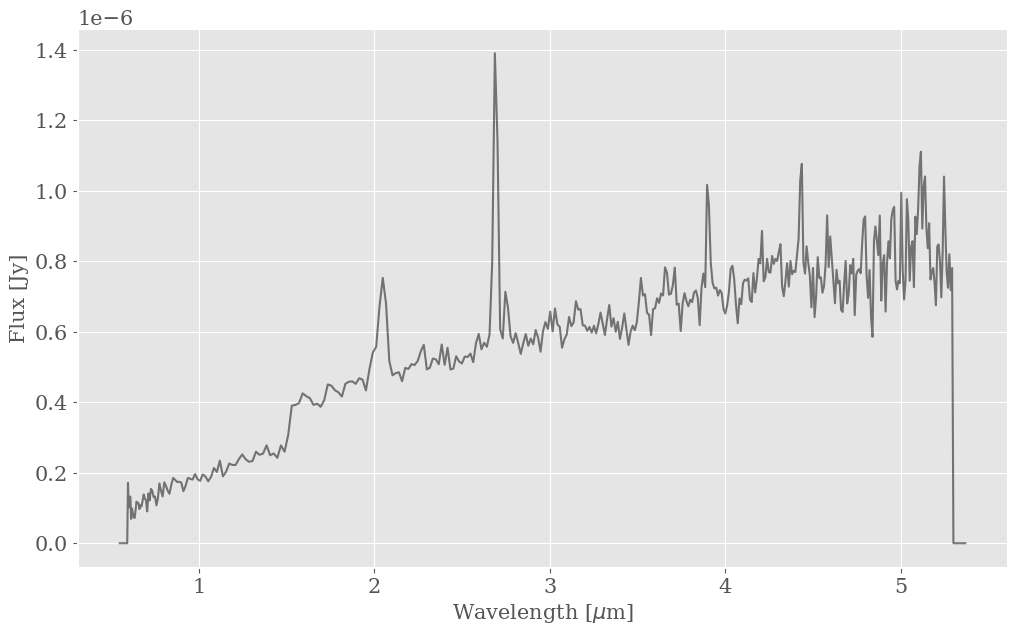

In [ ]:
#plotting Spectrum
plt.figure(figsize = (12, 7))

plt.plot(wavelength_nirspec, flux_nirspec, color = 'black', alpha = 0.5)

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

In [ ]:
#removing right-most data as that is all zeroes
wavelength_nirspec, flux_nirspec = wavelength_nirspec[:-10], flux_nirspec[:-10]

In [ ]:
#emission lines to check the redshift of this source
line_names = [r'H$\beta$', '[OIII]5007', r'H$\alpha$']
line_wavelengths = np.array([4864, 5007, 6564])

In [ ]:
#input your guess for a redshift here
#NOTE: The big peak is Halpha so try to match H-alpha to that
z = 

#line that redshifts the lines
redshifted_lines = ((1+z) * line_wavelengths) * u.AA.to(u.micrometer)

#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec)

plt.axvline(redshifted_lines[0], color = 'black')
plt.annotate(line_names[0], (redshifted_lines[0]-0.2, 1.3e-6))
plt.axvline(redshifted_lines[1], color = 'black')
plt.annotate(line_names[1], (redshifted_lines[1]+0.01, 1.1e-6))
plt.axvline(redshifted_lines[2], color = 'black')
plt.annotate(line_names[2], (redshifted_lines[2]+0.1, 1.2e-6))

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

SyntaxError: invalid syntax (434123282.py, line 3)

In [ ]:
#Fitting Continuum
nirspec_medfilt = medfilt(flux_nirspec, 101)
nirspec_savgol = savgol_filter(flux_nirspec, 101, 3)

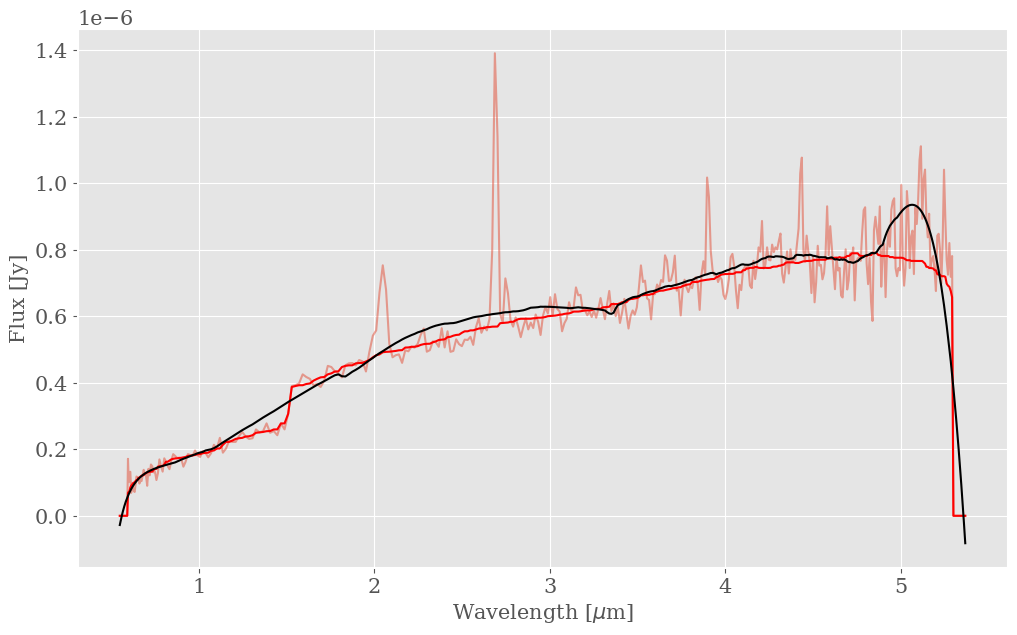

In [ ]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)

plt.plot(wavelength_nirspec, nirspec_medfilt, color = 'red')
plt.plot(wavelength_nirspec, nirspec_savgol, color = 'black')

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.show()

# Fitting Emission Lines

The key to working with spectra is being able to measure the line flux of an emission line. This is done by fitting a Gaussian model to the emission line. This process can be a bit more complicated if the lines are blended, meaning that what looks to be one line in the spectra is actually made up of a variety of other emission lines. In the next section we go over how to fit an emission line and slowly increase the complexity of the model and fitting routines.

In [ ]:
#subtract continuum for this first fitting method
cont_sub_nirspec_flux = flux_nirspec - nirspec_medfilt

Text(0, 0.5, 'Flux [Jy]')

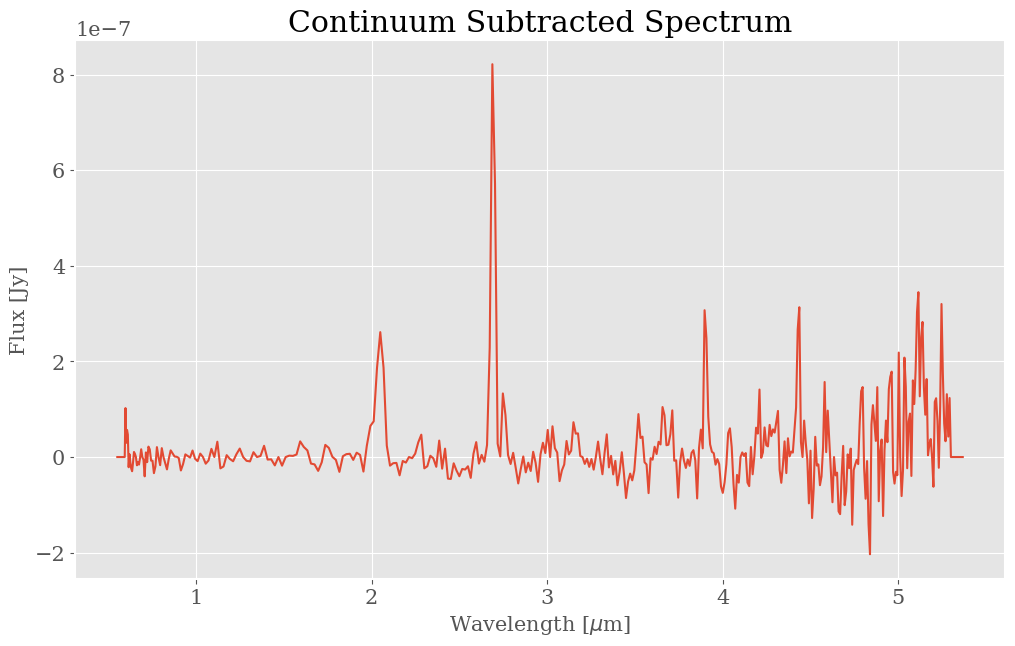

In [ ]:
plt.figure(figsize = (12, 7))
plt.title('Continuum Subtracted Spectrum')
plt.plot(wavelength_nirspec, cont_sub_nirspec_flux)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

# Using Curve Fit

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
#defining the model for the emission line as a Gaussian
def line_model(x, A, mu, sigma):
    
    '''
    This is the model for the emission line. Only to be used on a continuum subtracted spectrum.
    
    Gauss = Ae^(-(x-mu)^2/sigma^2)
    
    '''
    
    return A*np.exp(-(x - mu)**2/(sigma**2))

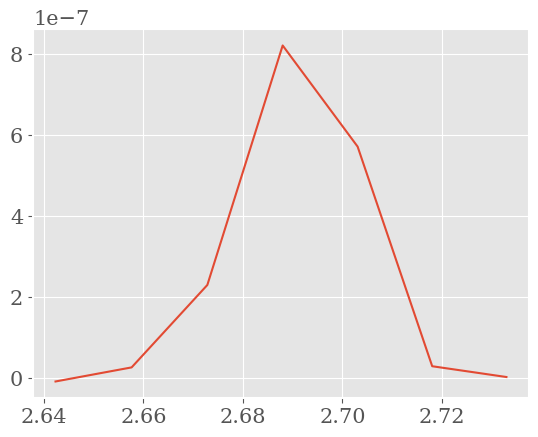

In [ ]:
#selecting the region of the spectrum just around the emission line
select_window = .05
idx_line_region = np.where((redshifted_lines[-1] - select_window < wavelength_nirspec) & \
                            (wavelength_nirspec < redshifted_lines[-1] +select_window))

plt.plot(wavelength_nirspec[idx_line_region], cont_sub_nirspec_flux[idx_line_region])
plt.show()

In [ ]:
#curve_fit requires initial guesses for it to start the fitting
#p0 will hold the initial guess on the parameters A, mu, and sigma for the line model
p0 = [8e-7, redshifted_lines[-1], .02]

#code that performs the least square fitting
popt, cov = curve_fit(line_model, #function to fit
                      wavelength_nirspec[idx_line_region], #xdata
                      cont_sub_nirspec_flux[idx_line_region], #ydata
                      p0 = p0) #initial guesses

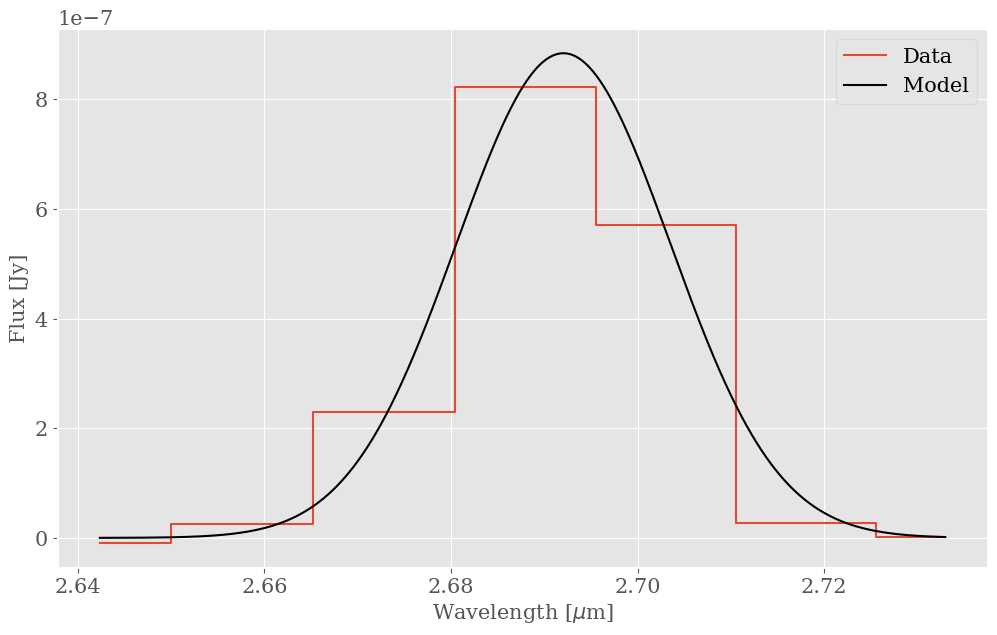

In [ ]:
#xarray to use for plotting the model against the data
xarr = np.linspace(wavelength_nirspec[idx_line_region][0], 
                  wavelength_nirspec[idx_line_region][-1], 
                   1000)

plt.figure(figsize = (12, 7))
l1, = plt.step(wavelength_nirspec[idx_line_region], 
         cont_sub_nirspec_flux[idx_line_region], 
         where = 'mid')
l2, = plt.plot(xarr, line_model(xarr, *popt), color = 'black')

plt.legend(handles = [l1, l2], 
          labels = ['Data', 
                    'Model'], 
          fontsize = 15)

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.show()


# A bit more complicated model

The last example showed us how we can use curve_fit to fit a Gaussian to the emission lines with the continuum subtracted, in this next example we are going to add in a bit more complexity by not removing the continuum but fitting it as well. We will do this by making the model near the emission line to be a combination of a Gaussian and a line. We use a Gaussian because that is what the line will be and the line will represent the continuum. 

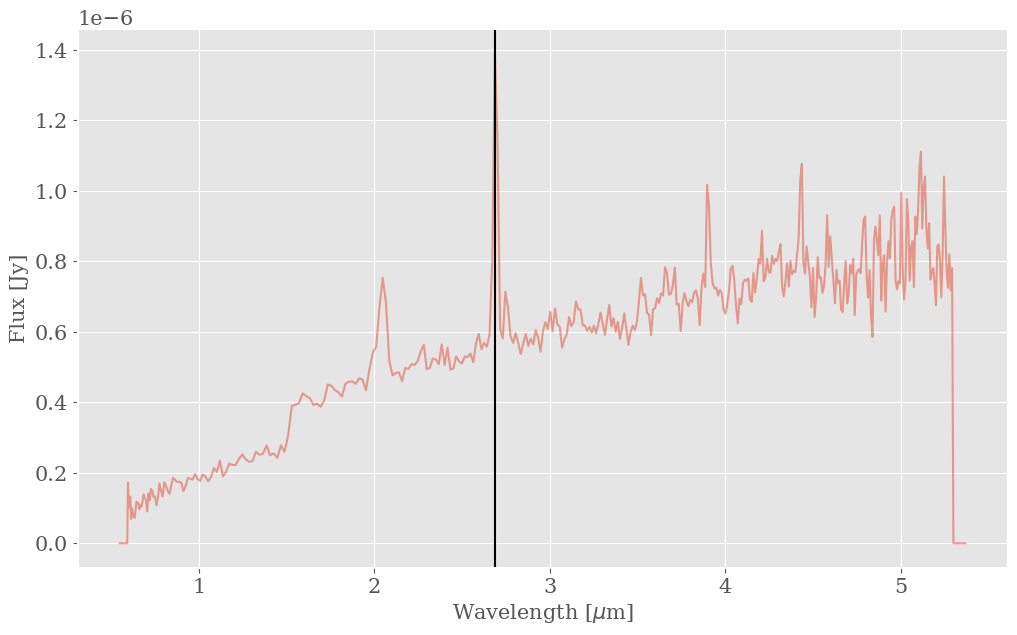

In [ ]:
#plotting the spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.axvline(2.69, color = 'black')
plt.show()

In [99]:
def continuum_model(x, m, b):

    continuum = m*(x - line_center) + b  #similar to y = mx+b

    return continuum

def gaussian_model(x, A, mu, sigma):

    gauss = A*np.exp(-(x - mu)**2/(2*sigma**2))

    return gauss

In [100]:
def line_plus_continuum(x, A, mu, sigma, m, b):
    
    '''
    Making the line plus gaussian model to use into curve_fit. 
    
    Model = Gaussian + line
    Model = Ae^(-(x-mu)^2/sigma^2) + m(x - line_center) + b
    '''
    
    line = gaussian_model(x, A, mu, sigma)
    continuum = continuum_model(x, m, b)
    
    return line + continuum

In [85]:
line_center = 2.69

In [101]:
#As with the previous example we need an initial guess for curve_fit but now we added in two more parameters
#so the initial guesses will be for A, mu, sigma, m, and b

#.       A              mu         sigma   m  b
p0 = [1.4e-6, redshifted_lines[-1], .02, .01, 0]

popt, cov = curve_fit(line_plus_continuum, #model
                      wavelength_nirspec[idx_line_region], #xdata
                      flux_nirspec[idx_line_region], #ydata
                      p0 = p0) #initial guesses

In [102]:
xarr = np.linspace(wavelength_nirspec[idx_line_region][0], 
                   wavelength_nirspec[idx_line_region][-1], 
                   1000)

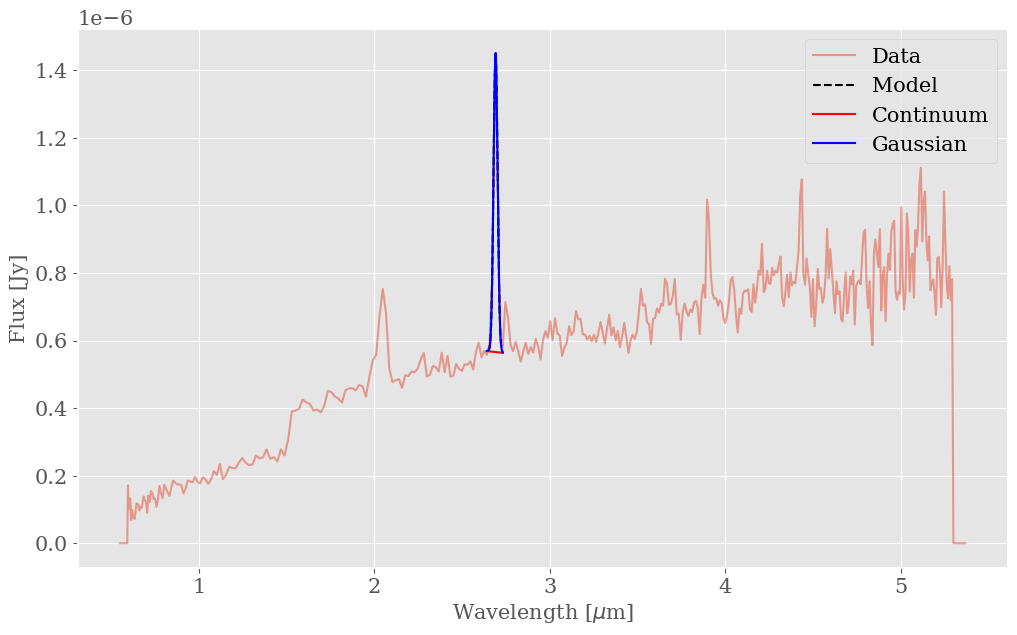

In [105]:

continuum_line = continuum_model(xarr, popt[-2], popt[-1])
gauss_line = gaussian_model(xarr, popt[0], popt[1], popt[2]) + continuum_line


plt.figure(figsize = (12, 7))
l1, = plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)
l2, = plt.plot(xarr, line_plus_continuum(xarr, *popt), color = 'black', linestyle = '--')
l3, = plt.plot(xarr, continuum_line, color = 'red')
l4, = plt.plot(xarr, gauss_line, color = 'blue')

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.legend(handles = [l1, l2, l3, l4], 
          labels = ['Data', 
                    'Model', 
                    'Continuum',
                    'Gaussian'], 
          fontsize = 15)

plt.show()

# A bit more complicated example

The last example showed how to fit both the emission line and the continuum, in this example we are going to now add in a bit more complexity by fitting multiple lines. When you did the redshift match you may have noticed that the bump leftward of Halpha is actually a combination of [OIII]5007 and Hbeta but it is actually made up of three lines as [OIII]4969 is also in there. We are going to try to fit this line with the three models to get the flux for each line individually and we will do so by making a more complicated model and take some advantages of the [OIII] lines to simplify the fitting.

In [106]:
def gauss_model(x, A, mu, sigma):
    
    '''
    Basic Gaussian model 
    '''
    
    return A*np.exp(-(x-mu)**2/sigma**2)

def line(x, m, b):
    
    '''
    Basic Line model
    '''
    return m*(x - line_center)+b

def model(x, A1, A2, mu1, mu2, mu3, sigma1, sigma2, m, b):
    
    '''
    This will hold the models for the three gaussian plus the line model for the continuum
    '''
    
    #making the hbeta model A1, mu1 and sigma1 will be the values for Hbeta
    hbeta = gauss_model(x, A1, mu1, sigma1)
    
    
    #since OIII is the same species they would be affected the same so the sigma will be the same between 
    #these two lines
    #there is also a theoretical amplitude that is fixed A_5007/A_4969 = 3
    #We will use this to only fit for the amplitude for the 5007 and we will scale the 4969 based off of the 
    #5007 amplitude
    
    oiii4969 = gauss_model(x, A2/3, mu2, sigma2)
    oiii5007 = gauss_model(x, A2, mu3, sigma2)
    
    continuum = line(x, m, b)
    
    return hbeta+oiii4969+oiii5007+continuum

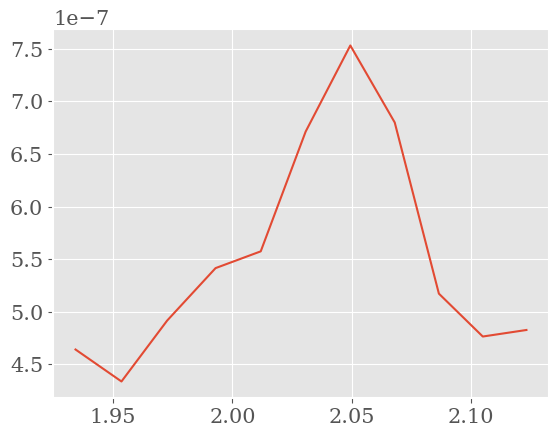

In [107]:
#selecting the region of the spectrum just around the emission line
select_window = .1
idx_line_region = np.where((2.03 - select_window < wavelength_nirspec) & \
                            (wavelength_nirspec < 2.03 +select_window))

plt.plot(wavelength_nirspec[idx_line_region], flux_nirspec[idx_line_region])
plt.show()

In [ ]:
redshifted_lines

In [108]:
#initial guesses for the model

#.     A1.   A2.       mu1                mu2.     mu3              sigma1 sigma2      m.   b
p0 = [4.5e-7, 6.5e-7, redshifted_lines[0], 2.037, redshifted_lines[1], .03,     .02, .4e-6, 0]

#imposing some upper and lower bounds on the parameters so that they do not go to any weird values
#this is useful if you know any priors on parameters such as Amplitudes or sigma widths
low_bounds =  (0   ,    0, 1.95, 1.95, 1.95,   0,   0, 0, -1)
high_bounds = (8e-7, 8e-7, 2.11, 2.11, 2.11, .1, .1, 10e-7, 1)

popt, cov = curve_fit(model, 
                      wavelength_nirspec[idx_line_region], 
                      flux_nirspec[idx_line_region], 
                      p0 = p0, 
                      bounds = (low_bounds, high_bounds))

In [ ]:
popt

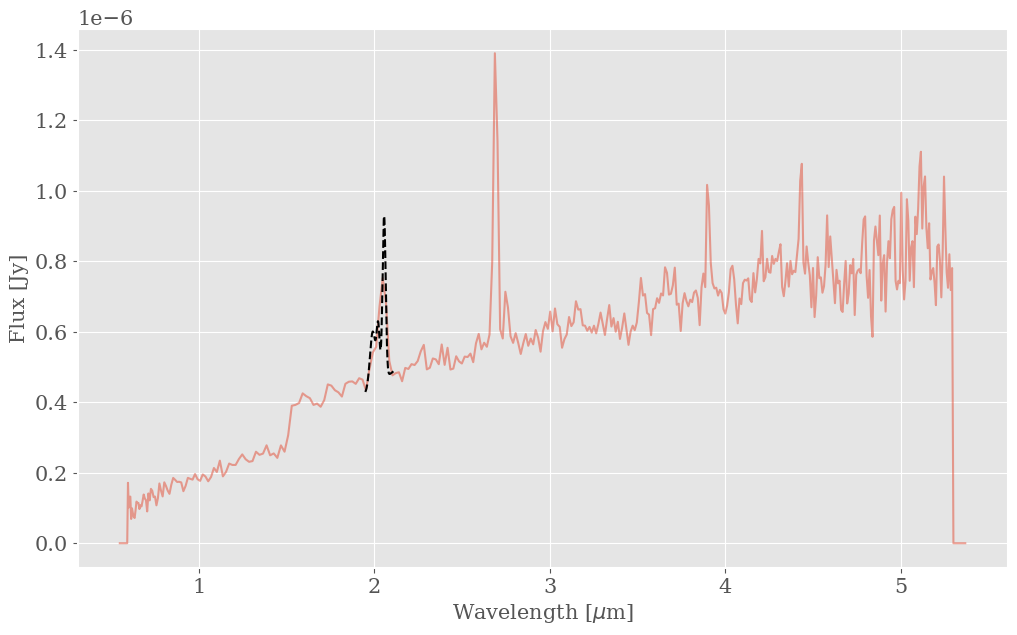

In [109]:
xarr = np.linspace(1.95, 2.11, 1000)
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)
plt.plot(xarr, model(xarr, *popt), color = 'black', linestyle = '--')
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

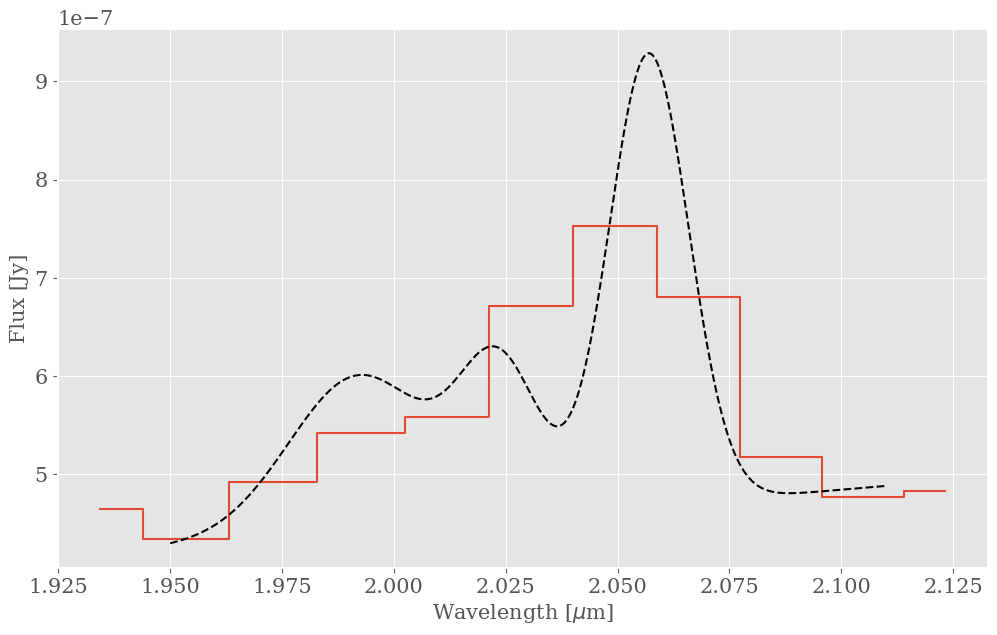

In [110]:
plt.figure(figsize = (12, 7))
plt.step(wavelength_nirspec[idx_line_region], flux_nirspec[idx_line_region], where = 'mid')
plt.plot(xarr, model(xarr, *popt), color = 'black', linestyle = '--')
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

In [4]:
y1 = np.linspace(1, 100, 100)
y1err = np.random.random(size = 100)

y2 = np.linspace(0, 500, 100)
y2err = np.random.random(size = 100)

In [6]:
Y = np.array([y1, y2])
Y_err = np.array([y1err, y2err])

100

# Stacking Spectra

Sometimes a single spectra may not have enough information that we would need to perform a calculation. This can be that an emission feature is too faint to be seen on an individual spectra but it can pop up when we take lots of similar galaxies and stack them. The trick with stacking is that you would want these gaalxies ot be as similar as possible in many properties such as redshift, mass, dust, metallicity, etc. Stacking spectra is essentially taking an average over many spectra and the advatnage to doing stacking is thta you can uncover features that are buried beneath the noise on an individual spectrum. Stacking reduces the noise and increases the signal across the board and below we go over how to do this. You will need an array of wavelengths, fluxes and flux errors. 

In [ ]:
def stack_spectra(wavelength, flux, flux_err, redshifts):
    
    '''
    Function to go through and stack the spectra
    
    Inputs
    -------------
    wavelength: a list or array of wavelengths
    flux: a list or array of fluxes
    flux_err: a list or array of flux errors
    
    Returns
    -------------
    
    '''
    
    redshift_array = np.array(redshifts)
    
    wavelengths = np.array(wavelength) 
    
    #Shifting the observed wavelengths to restframe wavelengths
    rest_frame_wavelength = wavelengths/(1+redshift_array)
    
    #getting the minimum and maximum wavelengths from the rest frame wavelengths
    wave_min = np.amin(rest_frame_wavelength)
    wave_max = np.amax(rest_frame_wavelength)
    
    #making an xarr at those min and max wavelength values
    xarr = np.linspace(wave_min, wave_max, 1000)
    
    undef = -999
    
    fluxes_2d = []
    
    for wave, fluxes in zip(wavelength, flux):
    #interpolated Spectra on the same wavelength grid as xarr
        interp_fluxes = np.array([np.interp(xarr, x, y, left = undef, right = undef) 
                                  for x, y in zip(rest_frame_wavelength, flux)])
    
    
        fluxes_2d.append(interp_fluxes)
        
    
    final_fluxes = np.array(fluxes_2d)
    
            
    errors = np.array(flux_err) #should be a 2D array of flux errors with each row being a different spectra and
                                #columns being the error on that pixel 
    
    weights = 1/errors**2
    
    weighted_avg = np.nansum(final_fluxes*weights, axis = 0)/np.nansum(weights, axis = 0)
    weighted_err = np.sqrt(1/np.nansum(weights, axis = 0))
    
    avg_spec = np.nanmean(final_fluxes, axis = 0)
    median_spec = np.nanmedian(final_fluxes, axis = 0)
    
    
    return 